# ECE9063 Project

Hyperparameters
- number of convolution layers
- number of filters
- filter size
- number of dense layers
- dense layer units
- batch size
- learning rate
- epochs
- kernel regularizer
- dropout

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

## Load data

In [3]:
folder_path = './Data/images/cropped'
target_size = (224, 224)
ignore_small = True
factor = 0.1

In [4]:
def load_data_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.utils.load_img(img_path, target_size=None)
        if ignore_small and (img.width < target_size[0]*factor or img.height < target_size[1]*factor):
            continue
        img = img.resize(target_size)
        img_array = tf.keras.utils.img_to_array(img)/255
        label = 1 if filename.endswith('T.png') else 0  # 1 for 'T' (with helmet), 0 for 'F' (without helmet)
        images.append(img_array)
        labels.append(int(label))
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_data_from_folder(folder_path)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [8]:
print(X_train.shape)
print(X_test.shape)

(914, 224, 224, 3)
(115, 224, 224, 3)


In [9]:
unique_elements, counts = np.unique(y_train, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} occurrences")

0: 260 occurrences
1: 654 occurrences


In [10]:
def plot_cost_function(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('CNN Training Accuracy')
    plt.legend()

    # Show the plot
    plt.show()

In [11]:
print(y_val.shape)
print(y_test.shape)

(114,)
(115,)


In [12]:
def print_metrics(model):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    y_pred = np.round(model.predict(X_test)).astype(int)
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Without Helmet', 'With Helmet'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

In [13]:
additional_metrics = [Precision(), Recall()]

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# CNN

## Base Model

### sigmoid

In [15]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Epoch 1/10
29/29 [==============================] - 6s 186ms/step - loss: 0.5113 - accuracy: 0.7582 - precision: 0.7801 - recall: 0.9220 - val_loss: 0.4493 - val_accuracy: 0.8246 - val_precision: 0.8537 - val_recall: 0.8974
Epoch 2/10
29/29 [==============================] - 5s 187ms/step - loss: 0.4257 - accuracy: 0.8326 - precision: 0.8523 - recall: 0.9266 - val_loss: 0.4087 - val_accuracy: 0.8509 - val_precision: 0.8506 - val_recall: 0.9487
Epoch 3/10
29/29 [==============================] - 5s 188ms/step - loss: 0.3594 - accuracy: 0.8479 - precision: 0.8642 - recall: 0.9343 - val_loss: 0.3971 - val_accuracy: 0.8246 - val_precision: 0.8372 - val_recall: 0.9231
Epoch 4/10
29/29 [==============================] - 6s 190ms/step - loss: 0.2945 - accuracy: 0.8709 - precision: 0.8907 - recall: 0.9343 - val_loss: 0.3789 - val_accuracy: 0.8333 - val_precision: 0.8734 - val_recall: 0.8846
Epoch 5/10
29/29 [==============================] - 5s 184ms/step - loss: 0.3030 - accuracy: 0.8621 - pr

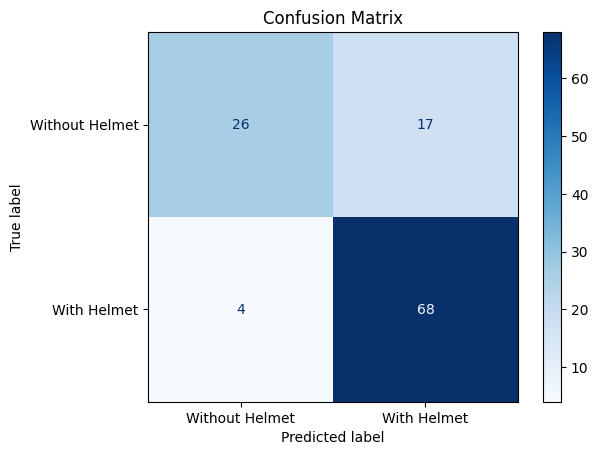

F1 Score: 0.8662


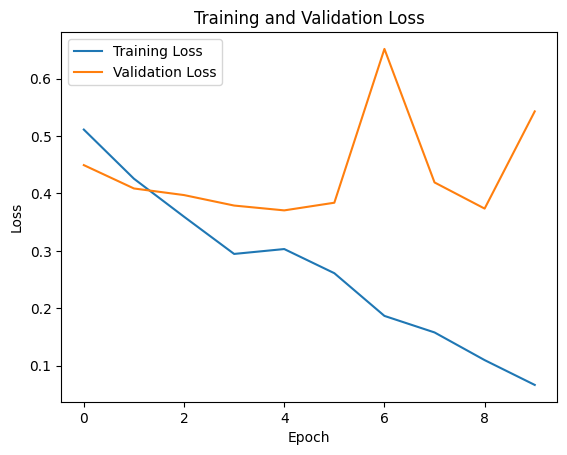

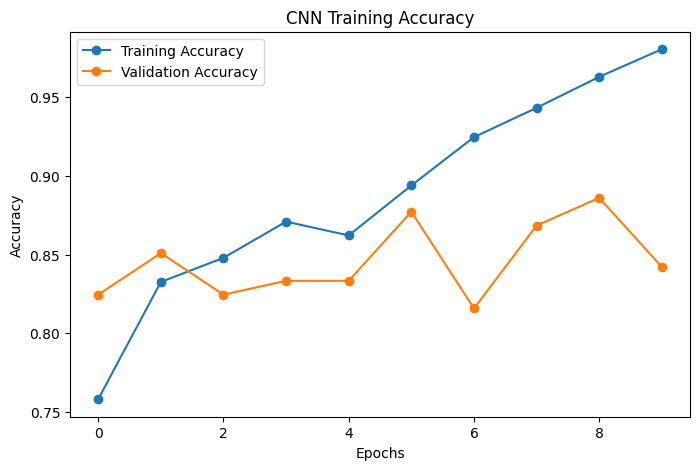

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### softmax

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### relu

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

### L2 regularizer

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function(history)

## Bayesian Optimization

In [21]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import keras
from sklearn.base import BaseEstimator, ClassifierMixin

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

In [23]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_filters_0=16, num_filters_1=16, num_filters_2=16, num_units_0=16, num_units_1=16):
        self.num_filters_0 = num_filters_0
        self.num_filters_1 = num_filters_1
        self.num_filters_2 = num_filters_2
        self.num_units_0 = num_units_0
        self.num_units_1 = num_units_1
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(self.num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        #model.add(Dropout(self.dropout_rate))
        model.add(Conv2D(self.num_filters_1, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        #model.add(Dropout(self.dropout_rate))
        model.add(Conv2D(self.num_filters_2, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(self.num_units_0, activation='relu'))
        model.add(Dense(self.num_units_1, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.num_filters_0,self.num_filters_1,self.num_filters_2,self.num_units_0,self.num_units_1)
        self.model.fit(X, y, epochs=10, validation_data=(X_val, y_val), callbacks=None)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

In [24]:
def val_accuracy_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    val_accuracy = accuracy_score(y, y_pred)
    print("Score: ",val_accuracy)
    return val_accuracy

In [25]:
hp_space = {
    'num_filters_0': (16, 128),
    'num_filters_1': (16, 128),
    'num_filters_2': (16, 128),
    'num_units_0' : (16, 128),
    'num_units_1' : (16, 128),
}

In [26]:
keras_model_wrapper = KerasClassifierWrapper()

In [27]:
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space,
    n_iter=10,
    cv=3,
    scoring=val_accuracy_scorer,
    random_state=42,
)

In [28]:
opt.fit(X_train, y_train)

62 98 120 51 91
Epoch 1/10
20/20 [==============================] - 3s 133ms/step - loss: 0.9076 - accuracy: 0.6782 - val_loss: 0.8669 - val_accuracy: 0.6842
Epoch 2/10
20/20 [==============================] - 3s 130ms/step - loss: 0.7900 - accuracy: 0.7159 - val_loss: 0.7619 - val_accuracy: 0.6842
Epoch 3/10
20/20 [==============================] - 3s 134ms/step - loss: 0.7281 - accuracy: 0.7159 - val_loss: 0.7005 - val_accuracy: 0.6842
Epoch 4/10
20/20 [==============================] - 3s 130ms/step - loss: 0.6677 - accuracy: 0.7225 - val_loss: 0.6506 - val_accuracy: 0.6930
Epoch 5/10
20/20 [==============================] - 3s 129ms/step - loss: 0.6323 - accuracy: 0.7586 - val_loss: 0.6251 - val_accuracy: 0.7456
Epoch 6/10
20/20 [==============================] - 3s 130ms/step - loss: 0.5974 - accuracy: 0.7931 - val_loss: 0.6266 - val_accuracy: 0.7456
Epoch 7/10
20/20 [==============================] - 3s 131ms/step - loss: 0.5694 - accuracy: 0.8046 - val_loss: 0.6259 - val_accurac

Score:  0.8262295081967214
62 98 120 51 91
Epoch 1/10
20/20 [==============================] - 3s 131ms/step - loss: 0.9152 - accuracy: 0.6831 - val_loss: 0.8761 - val_accuracy: 0.6842
Epoch 2/10
20/20 [==============================] - 3s 133ms/step - loss: 0.8173 - accuracy: 0.7159 - val_loss: 0.8341 - val_accuracy: 0.6842
Epoch 3/10
20/20 [==============================] - 3s 129ms/step - loss: 0.7589 - accuracy: 0.7159 - val_loss: 0.7766 - val_accuracy: 0.6842
Epoch 4/10
20/20 [==============================] - 3s 131ms/step - loss: 0.7280 - accuracy: 0.7159 - val_loss: 0.7259 - val_accuracy: 0.6842
Epoch 5/10
20/20 [==============================] - 3s 131ms/step - loss: 0.6583 - accuracy: 0.7159 - val_loss: 0.7248 - val_accuracy: 0.6842
Epoch 6/10
20/20 [==============================] - 3s 130ms/step - loss: 0.6387 - accuracy: 0.7438 - val_loss: 0.6362 - val_accuracy: 0.7105
Epoch 7/10
20/20 [==============================] - 3s 127ms/step - loss: 0.6150 - accuracy: 0.8013 - val

Score:  0.780327868852459
62 98 120 51 91
Epoch 1/10
20/20 [==============================] - 3s 143ms/step - loss: 0.8991 - accuracy: 0.7033 - val_loss: 0.8546 - val_accuracy: 0.6842
Epoch 2/10
20/20 [==============================] - 3s 130ms/step - loss: 0.7890 - accuracy: 0.7148 - val_loss: 0.7797 - val_accuracy: 0.6842
Epoch 3/10
20/20 [==============================] - 3s 131ms/step - loss: 0.7233 - accuracy: 0.7148 - val_loss: 0.7053 - val_accuracy: 0.6842
Epoch 4/10
20/20 [==============================] - 3s 135ms/step - loss: 0.6548 - accuracy: 0.7148 - val_loss: 0.6841 - val_accuracy: 0.6842
Epoch 5/10
20/20 [==============================] - 3s 129ms/step - loss: 0.6201 - accuracy: 0.7262 - val_loss: 0.6057 - val_accuracy: 0.7632
Epoch 6/10
20/20 [==============================] - 3s 133ms/step - loss: 0.5727 - accuracy: 0.8279 - val_loss: 0.5704 - val_accuracy: 0.7895
Epoch 7/10
20/20 [==============================] - 3s 134ms/step - loss: 0.5437 - accuracy: 0.8344 - val_

110 115 50 123 113
Epoch 1/10
20/20 [==============================] - 3s 142ms/step - loss: 0.9165 - accuracy: 0.6864 - val_loss: 0.8752 - val_accuracy: 0.6842
Epoch 2/10
20/20 [==============================] - 3s 133ms/step - loss: 0.8293 - accuracy: 0.7159 - val_loss: 0.8390 - val_accuracy: 0.6842
Epoch 3/10
20/20 [==============================] - 3s 137ms/step - loss: 0.7816 - accuracy: 0.7159 - val_loss: 0.7885 - val_accuracy: 0.6842
Epoch 4/10
20/20 [==============================] - 3s 144ms/step - loss: 0.7250 - accuracy: 0.7159 - val_loss: 0.7404 - val_accuracy: 0.6842
Epoch 5/10
20/20 [==============================] - 3s 139ms/step - loss: 0.6756 - accuracy: 0.7159 - val_loss: 0.6927 - val_accuracy: 0.6842
Epoch 6/10
20/20 [==============================] - 3s 143ms/step - loss: 0.6243 - accuracy: 0.7159 - val_loss: 0.6303 - val_accuracy: 0.6842
Epoch 7/10
20/20 [==============================] - 3s 144ms/step - loss: 0.5898 - accuracy: 0.7603 - val_loss: 0.6074 - val_accu

110 115 50 123 113
Epoch 1/10
20/20 [==============================] - 3s 139ms/step - loss: 0.9187 - accuracy: 0.7143 - val_loss: 0.8870 - val_accuracy: 0.6842
Epoch 2/10
20/20 [==============================] - 3s 133ms/step - loss: 0.8158 - accuracy: 0.7159 - val_loss: 0.8202 - val_accuracy: 0.6842
Epoch 3/10
20/20 [==============================] - 3s 134ms/step - loss: 0.7387 - accuracy: 0.7159 - val_loss: 0.7067 - val_accuracy: 0.7368
Epoch 4/10
20/20 [==============================] - 3s 135ms/step - loss: 0.6365 - accuracy: 0.8128 - val_loss: 0.6191 - val_accuracy: 0.8246
Epoch 5/10
20/20 [==============================] - 3s 141ms/step - loss: 0.5623 - accuracy: 0.8522 - val_loss: 0.6241 - val_accuracy: 0.7807
Epoch 6/10
20/20 [==============================] - 3s 143ms/step - loss: 0.5188 - accuracy: 0.8604 - val_loss: 0.5734 - val_accuracy: 0.8596
Epoch 7/10
20/20 [==============================] - 3s 144ms/step - loss: 0.5166 - accuracy: 0.8489 - val_loss: 0.5730 - val_accu

110 115 50 123 113
Epoch 1/10
20/20 [==============================] - 3s 138ms/step - loss: 0.9251 - accuracy: 0.6803 - val_loss: 0.8916 - val_accuracy: 0.6842
Epoch 2/10
20/20 [==============================] - 3s 133ms/step - loss: 0.8236 - accuracy: 0.7148 - val_loss: 0.8323 - val_accuracy: 0.6842
Epoch 3/10
20/20 [==============================] - 3s 137ms/step - loss: 0.7762 - accuracy: 0.7148 - val_loss: 0.7989 - val_accuracy: 0.6842
Epoch 4/10
20/20 [==============================] - 3s 144ms/step - loss: 0.7304 - accuracy: 0.7246 - val_loss: 0.7828 - val_accuracy: 0.6842
Epoch 5/10
13/20 [==================>...........] - ETA: 0s - loss: 0.6991 - accuracy: 0.7212

KeyboardInterrupt: 

In [158]:
best_params = opt.best_params_
print(best_params)

OrderedDict([('num_filters_0', 123), ('num_filters_1', 94), ('num_filters_2', 114), ('num_units_0', 63), ('num_units_1', 59)])


In [104]:
def opt_cnn_model(learning_rate, num_filters_0, num_filters_1, num_filters_2, num_units_0, num_units_1):
    model = Sequential()
    model.add(Conv2D(num_filters_0, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Conv2D(num_filters_1, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))
    model.add(Conv2D(num_filters_2, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(num_units_0, activation='relu'))
    model.add(Dense(num_units_1, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'] + additional_metrics)
    return model

Epoch 1/10
29/29 [==============================] - 55s 2s/step - loss: 1.8546 - accuracy: 0.6871 - precision_2: 0.7108 - recall_2: 0.9373 - val_loss: 1.0750 - val_accuracy: 0.7895 - val_precision_2: 0.7925 - val_recall_2: 0.9767
Epoch 2/10
29/29 [==============================] - 55s 2s/step - loss: 0.9258 - accuracy: 0.7899 - precision_2: 0.8063 - recall_2: 0.9201 - val_loss: 0.9417 - val_accuracy: 0.6579 - val_precision_2: 0.9608 - val_recall_2: 0.5698
Epoch 3/10
29/29 [==============================] - 67s 2s/step - loss: 0.7028 - accuracy: 0.7823 - precision_2: 0.8003 - recall_2: 0.9169 - val_loss: 0.6010 - val_accuracy: 0.8421 - val_precision_2: 0.9146 - val_recall_2: 0.8721
Epoch 4/10
29/29 [==============================] - 70s 2s/step - loss: 0.5560 - accuracy: 0.8228 - precision_2: 0.8480 - recall_2: 0.9091 - val_loss: 0.4794 - val_accuracy: 0.8596 - val_precision_2: 0.9167 - val_recall_2: 0.8953
Epoch 5/10
29/29 [==============================] - 66s 2s/step - loss: 0.5028 -

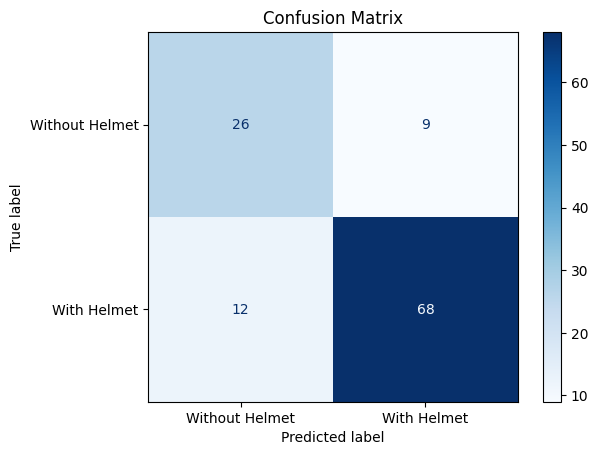

F1 Score: 0.8662


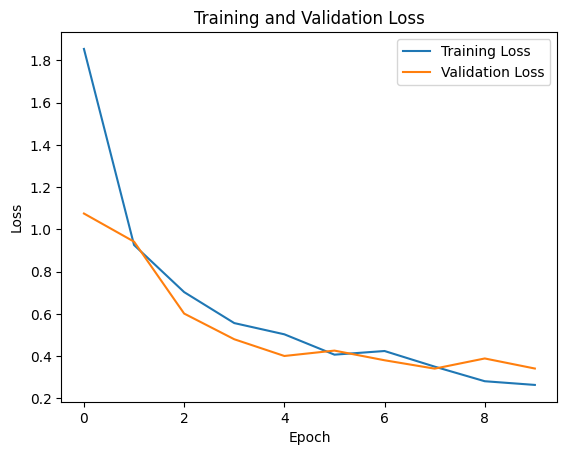

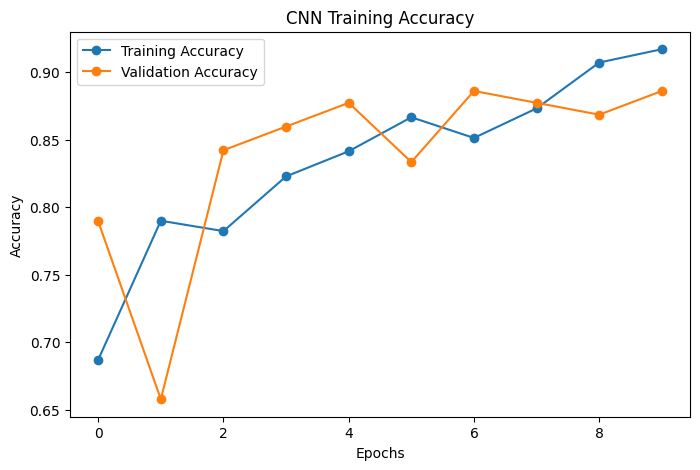

In [177]:
model = opt_cnn_model(0.001, 123, 94, 114, 63, 59)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)
print_metrics(model)
plot_cost_function(history)

# MLP

In [31]:
def plot_cost_function_mlp(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('MLP Training Accuracy')
    plt.legend()

    # Show the plot
    plt.show()

## Base Model

### sigmoid

Epoch 1/10
29/29 [==============================] - 2s 57ms/step - loss: 7.7296 - accuracy: 0.5897 - precision: 0.7232 - recall: 0.7163 - val_loss: 0.8217 - val_accuracy: 0.7544 - val_precision: 0.8289 - val_recall: 0.8077
Epoch 2/10
29/29 [==============================] - 2s 56ms/step - loss: 0.9582 - accuracy: 0.7363 - precision: 0.8105 - recall: 0.8242 - val_loss: 2.1905 - val_accuracy: 0.6930 - val_precision: 0.6903 - val_recall: 1.0000
Epoch 3/10
29/29 [==============================] - 2s 53ms/step - loss: 0.9512 - accuracy: 0.7298 - precision: 0.7954 - recall: 0.8379 - val_loss: 0.6979 - val_accuracy: 0.7281 - val_precision: 0.8615 - val_recall: 0.7179
Epoch 4/10
29/29 [==============================] - 2s 54ms/step - loss: 0.7575 - accuracy: 0.7571 - precision: 0.8243 - recall: 0.8394 - val_loss: 0.5298 - val_accuracy: 0.7544 - val_precision: 0.8049 - val_recall: 0.8462
Epoch 5/10
29/29 [==============================] - 1s 51ms/step - loss: 0.7527 - accuracy: 0.7582 - precisi

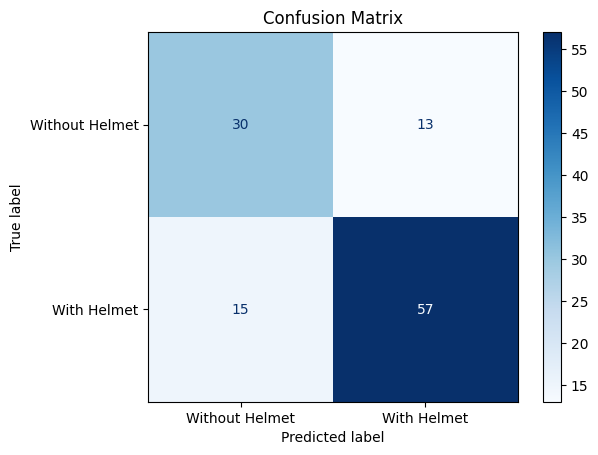

F1 Score: 0.8028


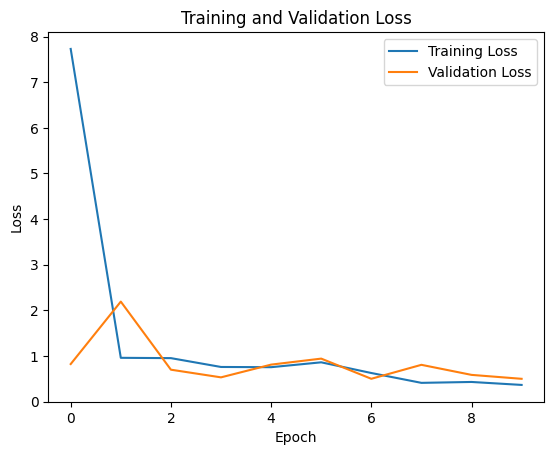

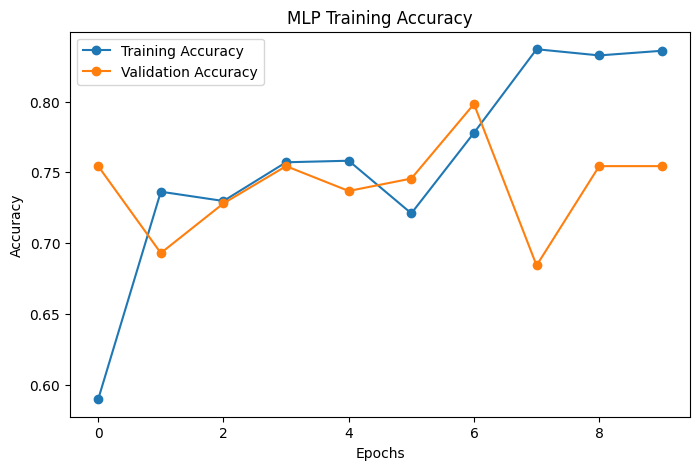

In [32]:
model = Sequential()
model.add(Flatten(input_shape=(target_size[0], target_size[1], 3)))  
model.add(Dense(128, activation='relu'))  
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))  
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function_mlp(history)

### softmax

Epoch 1/10
29/29 [==============================] - 2s 73ms/step - loss: 5.7062 - accuracy: 0.7155 - precision: 0.7279 - recall: 0.9876 - val_loss: 1.5793 - val_accuracy: 0.6842 - val_precision: 0.6842 - val_recall: 1.0000
Epoch 2/10
29/29 [==============================] - 2s 55ms/step - loss: 1.6865 - accuracy: 0.7155 - precision: 0.7155 - recall: 1.0000 - val_loss: 1.1901 - val_accuracy: 0.6842 - val_precision: 0.6842 - val_recall: 1.0000
Epoch 3/10
29/29 [==============================] - 2s 55ms/step - loss: 0.7038 - accuracy: 0.7155 - precision: 0.7155 - recall: 1.0000 - val_loss: 0.4858 - val_accuracy: 0.6842 - val_precision: 0.6842 - val_recall: 1.0000
Epoch 4/10
29/29 [==============================] - 2s 53ms/step - loss: 0.5258 - accuracy: 0.7155 - precision: 0.7155 - recall: 1.0000 - val_loss: 0.8778 - val_accuracy: 0.6842 - val_precision: 0.6842 - val_recall: 1.0000
Epoch 5/10
29/29 [==============================] - 2s 57ms/step - loss: 0.7713 - accuracy: 0.7155 - precisi

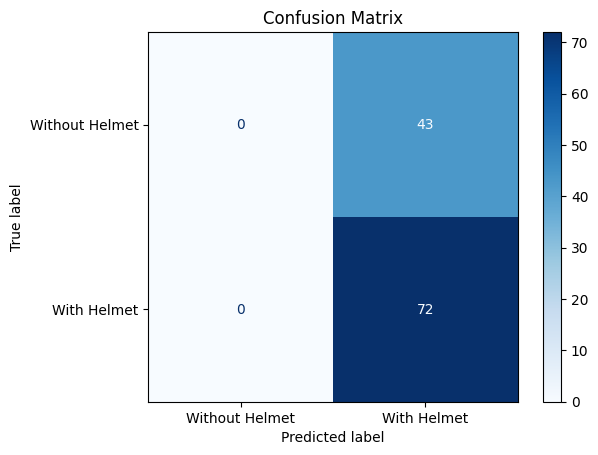

F1 Score: 0.7701


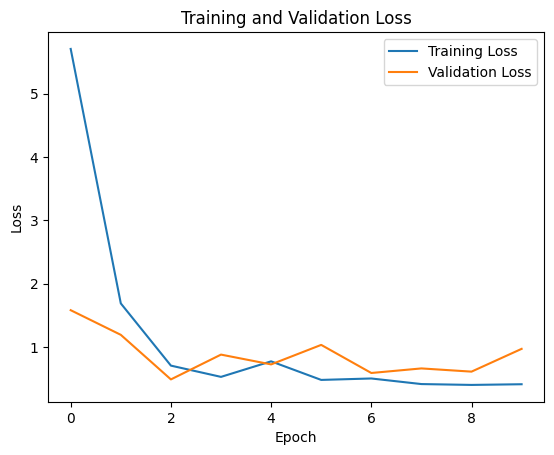

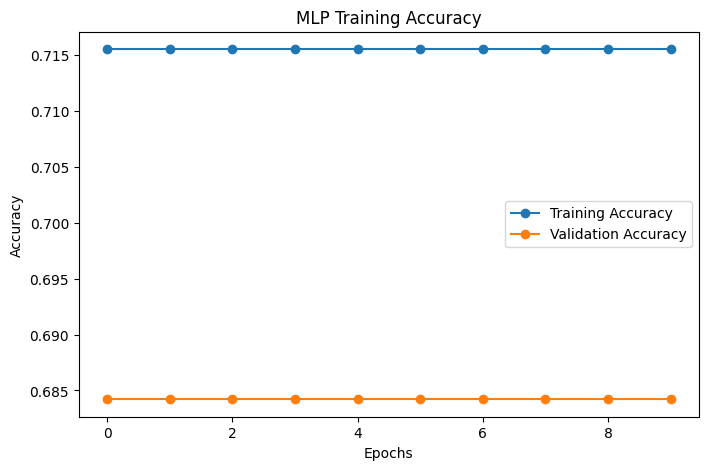

In [34]:
model = Sequential()
model.add(Flatten(input_shape=(target_size[0], target_size[1], 3))) 
model.add(Dense(128, activation='relu'))  
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))   
model.add(Dense(1, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function_mlp(history)

### relu

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(target_size[0], target_size[1], 3))) 
model.add(Dense(128, activation='relu'))  
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))   
model.add(Dense(1, activation='relu'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function_mlp(history)

### L2 regularizer

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(target_size[0], target_size[1], 3))) 
model.add(Dense(128, activation='relu')) 
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))   
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'] + additional_metrics)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)

print_metrics(model)
plot_cost_function_mlp(history)

## Bayesian Optimization

In [38]:
class KerasClassifierWrapper_mlp(BaseEstimator, ClassifierMixin):
    def __init__(self, num_units_0=128, num_units_1=256, num_units_2=256):
        self.num_units_0 = num_units_0
        self.num_units_1 = num_units_1
        self.num_units_2 = num_units_2
        self.classes_ = [0, 1]
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(target_size[0], target_size[1], 3)))  # Flatten the images
        model.add(Dense(self.num_units_0, activation='relu'))  
        model.add(Dense(self.num_units_1, activation='relu'))
        model.add(Dense(self.num_units_2, activation='relu'))   
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
        return model

    def fit(self, X, y):
        global X_val, y_val
        #X_val, y_val = X_val, y_val
        print(self.num_units_0,self.num_units_1,self.num_units_2)
        self.model.fit(X, y, epochs=10, validation_data=(X_val, y_val), callbacks=None)
        return self

    def predict(self, X):
        return np.round(self.model.predict(X))

In [39]:
def val_accuracy_scorer_mlp(estimator, X, y):
    y_pred = estimator.predict(X)
    val_accuracy = accuracy_score(y, y_pred)
    print("Score: ",val_accuracy)
    return val_accuracy

In [40]:
hp_space_mlp= {
    'num_units_0' : (16, 128),
    'num_units_1' : (16, 128),
    'num_units_2' : (16, 128),
}

In [41]:
keras_model_wrapper = KerasClassifierWrapper_mlp()

In [42]:
opt = BayesSearchCV(
    keras_model_wrapper,
    hp_space_mlp,
    n_iter=10,
    cv=3,
    scoring=val_accuracy_scorer,
    random_state=42,
)

In [ ]:
opt.fit(X_train, y_train)

In [ ]:
best_params = opt.best_params_
print(best_params)

In [ ]:
def opt_mpl_model(learning_rate,num_units_0, num_units_1,num_units_2):
    model = Sequential()
    model.add(Flatten(input_shape=(target_size[0], target_size[1], 3)))  # Flatten the images
        # Add Dense layers
    model.add(Dense(num_units_0, activation='relu'))  
    model.add(Dense(num_units_1, activation='relu'))
    model.add(Dense(num_units_2, activation='relu'))   
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'] + additional_metrics)
    return model

In [ ]:
model = opt_mpl_model(0.001, )
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=None)
print_metrics(model)
plot_cost_function_mlp(history)